In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.envs.darkroom import DarkroomEnv

# Load Model

In [2]:
corr = 0.25
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "darkroom_simple")


epoch=13-val_loss=0.911523.ckpt


In [3]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))
maze_dim = int(re.search(r'_dim(\d+)_corr', eval_dset_path).group(1))
node_encoding_corr = float(re.search(r'corr(\d*\.?\d*)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": state_dim,
    "action_dim": 5,
    "dropout": dropout,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
}

In [4]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_3392614/4170590101.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [5]:
n_eval_envs = 50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


In [6]:
def run_model(traj, model, state_features, seq_length, zero_reward=False):
    hidden_states = [[] for _ in range(model.n_layer)]
    
    for state_feature in state_features: 
        batch = {
            'context_states': convert_to_tensor([np.array(traj['context_states'])]),
            'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
            'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
            'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
            'query_states': convert_to_tensor([np.array(state_feature)]),
            }
        batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
        for k in batch.keys():
            if 'context' in k:
                batch[k] = batch[k][:,:seq_length]
            batch[k] = batch[k].to(model.device)
        model.save_activations = True
        if zero_reward:
            batch['context_rewards'] *= 0
        with torch.no_grad():
            out = model(batch)
        _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers
        for i_layer in range(model.n_layer):
            hidden_states[i_layer].append(_hidden_states[i_layer])
    return hidden_states

In [7]:
def make_pca_plots(xs, ys, reward_idx, hidden_states, dims=[0,1], figname=None):
    n_layers = len(hidden_states)
    fig, axs = plt.subplots(1, n_layers, figsize=(2.5, 0.9))
    
    # Create a dictionary mapping (x,y) to PCA coordinates for connecting neighbors
    for layer in range(n_layers):
        X = torch.stack(hidden_states[layer])
        X = X.detach().cpu().numpy().squeeze()
        data = X[:, -1, :]
        
        # Perform PCA
        pca = PCA(n_components=10)
        data_pca = pca.fit_transform(data)
        data_pca = data_pca / np.abs(data_pca).max(axis=0)
        
        # Create mapping of maze positions to PCA coordinates
        pos_to_pca = {(x, y): data_pca[i] for i, (x, y) in enumerate(zip(xs, ys))}
        
        # Plot connections first (so they appear behind points)
        for i, (x, y) in enumerate(zip(xs, ys)):
            # Connect to right neighbor
            if (x + 1, y) in pos_to_pca:
                axs[layer].plot([data_pca[i][dims[0]], pos_to_pca[(x + 1, y)][0]],
                              [data_pca[i][dims[1]], pos_to_pca[(x + 1, y)][1]],
                              'gray', alpha=0.3, linewidth=1.)
            # Connect to upper neighbor
            if (x, y + 1) in pos_to_pca:
                axs[layer].plot([data_pca[i][dims[0]], pos_to_pca[(x, y + 1)][0]],
                              [data_pca[i][dims[1]], pos_to_pca[(x, y + 1)][1]],
                              'gray', alpha=0.3, linewidth=1.)
        
        # Plot the points
        pt_mask = np.ones(len(data_pca), dtype=bool)
        pt_mask[reward_idx] = False

        # Single color mapping
        _xs = np.array(xs)
        _ys = np.array(ys)
        position_values = np.array(_xs + _ys*5)
        axs[layer].scatter(
            data_pca[pt_mask, dims[0]], data_pca[pt_mask, dims[1]],
            c=position_values[pt_mask], s=5,
            cmap='plasma',
            alpha=1.)        

        axs[layer].scatter(
            data_pca[reward_idx, dims[0]], data_pca[reward_idx, dims[1]],
            c='red', s=15,
            alpha=1., marker='*')
        
        axs[layer].set_aspect('equal', 'box')
        axs[layer].set_box_aspect(1)
        axs[layer].set_xticks([])
        axs[layer].set_yticks([])
        for spine in axs[layer].spines.values():
            spine.set_visible(True)
    
    plt.tight_layout(pad=0.2, w_pad=0.5)
    os.makedirs('figs_app/F_15', exist_ok=True)
    if figname is not None:
        plt.savefig('figs_app/F_15/' + figname + '.png', transparent=True, dpi=300)
        plt.savefig('figs_app/F_15/' + figname + '.pdf', transparent=True, dpi=300)
    plt.show()

# Making Plots

In [8]:
def make_plots(i_eval):
    traj = eval_trajs[i_eval]
    max_seq_length = 250
    
    env_config = {
        'maze_dim': maze_dim,
        'horizon': 200,
        'state_dim': state_dim,
        'node_encoding_corr': node_encoding_corr,
        'initialization_seed': np.array(traj['initialization_seed']).item(),
        'goal': np.array(traj['goal'])
    }
    env = DarkroomEnv(**env_config)
    
    xs = []
    ys = []
    state_features = []
    state_features = list(env.node_map_encoding_to_pos.keys())
    
    for state_feature in state_features:
        xs.append(env.node_map_encoding_to_pos[state_feature][0])
        ys.append(env.node_map_encoding_to_pos[state_feature][1])
    
    reward_idx = np.argwhere([np.all(s == env.goal) for s in state_features]).item()

    seq_lengths = [1, max_seq_length]
    for seq_length in seq_lengths:
        print(f'Sequence Length: {seq_length}')
        hidden_states = run_model(traj, model, state_features, seq_length)
        hidden_states_no_reward = run_model(traj, model, state_features, seq_length, zero_reward=True)
        make_pca_plots(xs, ys, reward_idx, hidden_states, figname=f'{i_eval}_{seq_length}')
        make_pca_plots(xs, ys, reward_idx, hidden_states_no_reward, figname=f'{i_eval}_{seq_length}_no_reward')
        # Clear GPU memory
        del hidden_states
        torch.cuda.empty_cache()

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Sequence Length: 1


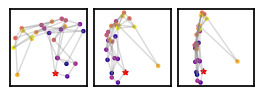

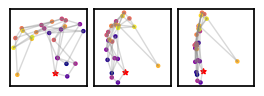

Sequence Length: 250


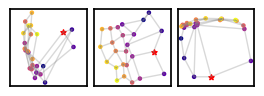

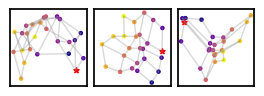

Sequence Length: 1


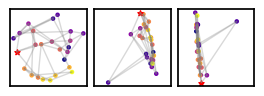

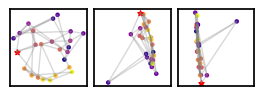

Sequence Length: 250


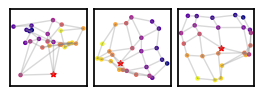

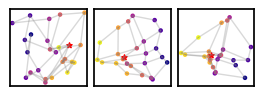

Sequence Length: 1


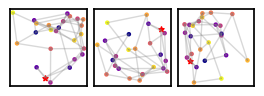

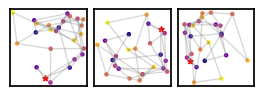

Sequence Length: 250


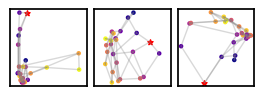

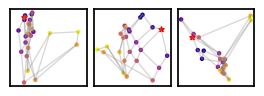

Sequence Length: 1


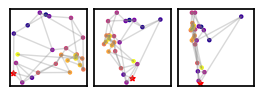

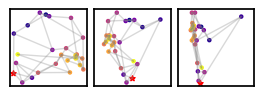

Sequence Length: 250


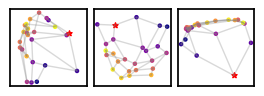

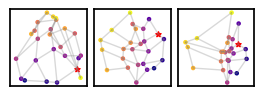

Sequence Length: 1


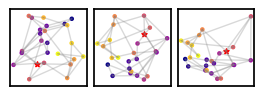

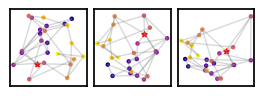

Sequence Length: 250


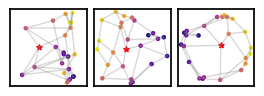

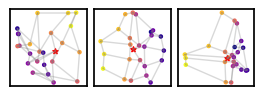

Sequence Length: 1


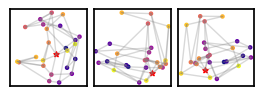

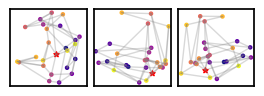

Sequence Length: 250


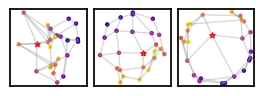

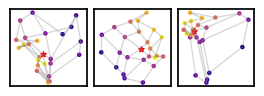

Sequence Length: 1


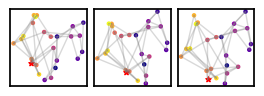

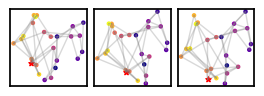

Sequence Length: 250


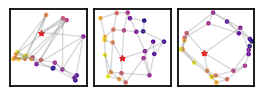

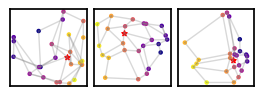

Sequence Length: 1


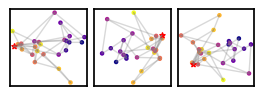

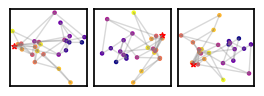

Sequence Length: 250


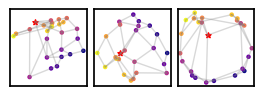

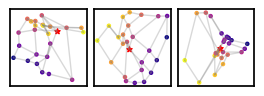

In [9]:
for i_eval in range(8):
    make_plots(i_eval)